In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import random
import gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import pygame
from math import pi, sin, cos, sqrt
from random import randrange
from gym import spaces
from pygame.locals import *
import matplotlib.pyplot as plt
import pylab
import threading
from threading import Lock
from torch.distributions import Categorical
import time
from gym.envs.registration import register

register(
    id='droneEnv-v0',
    entry_point='__main__:droneEnv',
)

class droneEnv(gym.Env):
    def __init__(self, render_every_frame=False, mouse_target=False):
        super(droneEnv, self).__init__()

        self.render_every_frame = render_every_frame
        self.mouse_target = mouse_target

        # Initialize Pygame, load sprites
        pygame.init()
        self.screen = pygame.display.set_mode((800, 800))
        self.FramePerSec = pygame.time.Clock()

        self.player = pygame.image.load(os.path.join(".../drone_old.png"))
        self.player.convert()

        self.target = pygame.image.load(os.path.join(".../target_old.png"))
        self.target.convert()

        pygame.font.init()
        self.myfont = pygame.font.SysFont("Comic Sans MS", 20)

        # Physics constants
        self.FPS = 60
        self.gravity = 0.08
        self.thruster_amplitude = 0.04
        self.diff_amplitude = 0.0006
        self.thruster_mean = 0.04
        self.mass = 1
        self.arm = 25
        self.target_counter = 0

        # Initialize variables
        (self.a, self.ad, self.add) = (0, 0, 0)
        (self.x, self.xd, self.xdd) = (400, 0, 0)
        (self.y, self.yd, self.ydd) = (400, 0, 0)
        self.xt = randrange(200, 600)
        self.yt = randrange(200, 600)

        # Initialize game variables
        self.reward = 0
        self.time = 0
        self.time_limit = 20
        if self.mouse_target:
            self.time_limit = 1000

        # 5 actions: Nothing, Up, Down, Right, Left
        self.action_space = gym.spaces.Discrete(5)
        # 7 observations: angle_to_up, velocity, angle_velocity, distance_to_target, angle_to_target, angle_target_and_velocity, distance_to_target
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(7,))

        self.spec = gym.envs.registration.EnvSpec(id='droneEnv-v0', entry_point=droneEnv)
        self.lock = threading.Lock()

    def reset(self):
        with self.lock:
            # Reset variables
            (self.a, self.ad, self.add) = (0, 0, 0)
            (self.x, self.xd, self.xdd) = (400, 0, 0)
            (self.y, self.yd, self.ydd) = (400, 0, 0)
            self.xt = randrange(200, 600)
            self.yt = randrange(200, 600)

            self.reward = 0
            self.time = 0

            return self.get_obs()

    def get_obs(self):
        angle_to_up = self.a / 180 * pi
        velocity = sqrt(self.xd**2 + self.yd**2)
        angle_velocity = self.ad
        distance_to_target = sqrt((self.xt - self.x) ** 2 + (self.yt - self.y) ** 2) / 500
        angle_to_target = np.arctan2(self.yt - self.y, self.xt - self.x)
        angle_target_and_velocity = angle_to_target - np.arctan2(self.yd, self.xd)
        distance_to_target = sqrt((self.xt - self.x) ** 2 + (self.yt - self.y) ** 2) / 500
        return np.array([
            angle_to_up,
            velocity,
            angle_velocity,
            distance_to_target,
            angle_to_target,
            angle_target_and_velocity,
            distance_to_target,
        ]).astype(np.float32)

    def step(self, action):
        with self.lock:
            self.reward = 0.0
            action = int(action)

            # Act every 5 frames
            for _ in range(5):
                self.time += 1 / 60

                if self.mouse_target:
                    self.xt, self.yt = pygame.mouse.get_pos()

                self.xdd = 0
                self.ydd = self.gravity
                self.add = 0
                thruster_left = self.thruster_mean
                thruster_right = self.thruster_mean

                if action == 0:
                    pass
                elif action == 1:
                    thruster_left += self.thruster_amplitude
                    thruster_right += self.thruster_amplitude
                elif action == 2:
                    thruster_left -= self.thruster_amplitude
                    thruster_right -= self.thruster_amplitude
                elif action == 3:
                    thruster_left += self.diff_amplitude
                    thruster_right -= self.diff_amplitude
                elif action == 4:
                    thruster_left -= self.diff_amplitude
                    thruster_right += self.diff_amplitude

                self.xdd += (-(thruster_left + thruster_right) * sin(self.a * pi / 180) / self.mass)
                self.ydd += (-(thruster_left + thruster_right) * cos(self.a * pi / 180) / self.mass)
                self.add += self.arm * (thruster_right - thruster_left) / self.mass

                self.xd += self.xdd
                self.yd += self.ydd
                self.ad += self.add
                self.x += self.xd
                self.y += self.yd
                self.a += self.ad

                dist = sqrt((self.x - self.xt) ** 2 + (self.y - self.yt) ** 2)

                self.reward += 1 / 60
                self.reward -= dist / (100 * 60)

                if dist < 50:
                    self.xt = randrange(200, 600)
                    self.yt = randrange(200, 600)
                    self.reward += 100
                    self.target_counter += 1

                if self.time > self.time_limit:
                    done = True
                    break
                elif dist > 1000:
                    self.reward -= 1000
                    done = True
                    break
                else:
                    done = False

                if self.render_every_frame:
                    self.render("yes")

            info = {}

            return self.get_obs(), self.reward, done, info

    def render(self, mode):
        with self.lock:
            pygame.event.get()
            self.screen.fill(0)
            self.screen.blit(
                self.target,
                (self.xt - int(self.target.get_width() / 2), self.yt - int(self.target.get_height() / 2)),
            )
            player_copy = pygame.transform.rotate(self.player, self.a)
            self.screen.blit(
                player_copy,
                (self.x - int(player_copy.get_width() / 2), self.y - int(player_copy.get_height() / 2)),
            )

            textsurface = self.myfont.render(
                "Collected: " + str(self.target_counter), False, (255, 255, 255)
            )
            self.screen.blit(textsurface, (20, 20))
            textsurface3 = self.myfont.render(
                "Time: " + str(int(self.time)), False, (255, 255, 255)
            )
            self.screen.blit(textsurface3, (20, 50))

            pygame.display.update()
            self.FramePerSec.tick(self.FPS)

    def close(self):
        pygame.quit()

class OurModel(nn.Module):
    def __init__(self, input_shape, action_space):
        super(OurModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(np.prod(input_shape), 512)
        self.fc2_action = nn.Linear(512, action_space)
        self.fc2_value = nn.Linear(512, 1)
        self.elu = nn.ELU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.elu(self.fc1(x))
        action = nn.Softmax(dim=-1)(self.fc2_action(x))
        value = self.fc2_value(x)
        return action, value

class A3CAgent:
    def __init__(self, env):
        self.env = env

        if self.env.unwrapped.spec is None:
            raise AttributeError("Provided environment has no spec. Ensure the environment is properly initialized.")

        self.action_size = self.env.action_space.n
        self.EPISODES, self.episode, self.max_average = 2000, 0, -100.0#-21
        self.lock = threading.Lock()
        self.state_size = self.env.observation_space.shape

        self.lr = 0.000025
        self.gamma = 0.95
        self.train_start = 1000
        self.max_episode_steps = 1000

        self.scores, self.episodes, self.average = [], [], []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.Actor = OurModel(input_shape=self.state_size, action_space=self.action_size).to(self.device)
        self.Critic = OurModel(input_shape=self.state_size, action_space=1).to(self.device)

        self.actor_optimizer = optim.Adam(self.Actor.parameters(), lr=self.lr)
        self.critic_optimizer = optim.Adam(self.Critic.parameters(), lr=self.lr)

    def load(self, actor_path, critic_path):
        self.Actor.load_state_dict(torch.load(actor_path))
        self.Critic.load_state_dict(torch.load(critic_path))

    def save(self):
        torch.save(self.Actor.state_dict(), '/content/A3C_Actor.pt')
        torch.save(self.Critic.state_dict(), '/content/A3C_Critic.pt')

    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores) / len(self.scores))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        try:
            pylab.savefig("D3NARL_Drone_1.png")
        except OSError:
            pass

        return str(self.average[-1])[:5]

    def remember(self, state, action, reward):
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_probs, _ = self.Actor(state)
        action_probs = action_probs.cpu().numpy()
        action_probs = np.nan_to_num(action_probs, nan=1e-10)  # Avoid NaN values
        dist = Categorical(torch.tensor(action_probs))
        action = dist.sample()
        return action.item()

    def discount_rewards(self, rewards):
        gamma = 0.99
        discounted_r = np.zeros_like(rewards)
        R = 0
        for i in reversed(range(len(rewards))):
            R = 0 if rewards[i] != 0 else R
            R = R * gamma + rewards[i]
            discounted_r[i] = R

        discounted_r = torch.tensor(discounted_r, dtype=torch.float32).to(self.device)
        if discounted_r.size(0) > 1:
            discounted_r = (discounted_r - discounted_r.mean()) / (discounted_r.std() + 1e-5)
        return discounted_r

    def replay(self, states, actions, rewards):
        states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in states]).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = self.discount_rewards(rewards)

        action_probs, values = self.Actor(states)
        values = values.squeeze()
        advantages = rewards - values.detach()

        dist = Categorical(action_probs)
        action_log_probs = dist.log_prob(actions)
        actor_loss = -(action_log_probs * advantages).mean()
        critic_loss = nn.functional.mse_loss(values, rewards.view_as(values))

        self.actor_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward(retain_graph=True)
        self.critic_optimizer.step()

    def train(self, n_threads):
        envs = [gym.make('droneEnv-v0') for _ in range(n_threads)]

        threads = [
            threading.Thread(target=self.train_threading, daemon=True, args=(envs[i], i))
            for i in range(n_threads)
        ]
        for t in threads:
            time.sleep(2)
            t.start()
        
        for t in threads:
            t.join()

    def train_threading(self, env, thread):
        while self.episode < self.EPISODES:
            score, done, SAVING = 0, False, ''
            state = env.reset()
            states, actions, rewards = [], [], []
            while not done:
                self.env.render('human')
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                score += reward
                state = next_state

            self.lock.acquire()
            try:
                self.replay(states, actions, rewards)

                average = self.PlotModel(score, self.episode)
                if float(average) >= self.max_average:
                    self.max_average = float(average)
                    self.save()
                    SAVING = "SAVING"
                else:
                    SAVING = ""
                average=float(average)
                score=float(score)
                print(f"episode: {self.episode}/{self.EPISODES}, thread: {thread}, score: {score:.2f}, average: {average:.2f} {SAVING}")
                if self.episode < self.EPISODES:
                    self.episode += 1
            finally:
                self.lock.release()

        env.close()


def env_creator(render_every_frame=True, mouse_target=False):
    return droneEnv(render_every_frame, mouse_target)


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
kwargs = {'render_every_frame': False, 'mouse_target': False}
env=droneEnv(**kwargs)
agent = A3CAgent(env)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


episode: 0/2000, thread: 0, score: -1009.63, average: -1009.00 
episode: 1/2000, thread: 0, score: -1000.15, average: -1004.00 
episode: 2/2000, thread: 0, score: -1000.16, average: -1003.00 
episode: 3/2000, thread: 0, score: -1000.16, average: -1002.00 
episode: 4/2000, thread: 0, score: -1000.16, average: -1002.00 
episode: 5/2000, thread: 0, score: -1000.16, average: -1001.00 
episode: 6/2000, thread: 0, score: -1000.16, average: -1001.00 
episode: 7/2000, thread: 0, score: -1000.17, average: -1001.00 
episode: 8/2000, thread: 0, score: -1000.17, average: -1001.00 
episode: 9/2000, thread: 0, score: -1000.17, average: -1001.00 
episode: 10/2000, thread: 0, score: -1000.17, average: -1001.00 
episode: 11/2000, thread: 0, score: -1000.17, average: -1000.00 
episode: 12/2000, thread: 0, score: -1000.18, average: -1000.00 
episode: 13/2000, thread: 0, score: -1000.18, average: -1000.00 
episode: 14/2000, thread: 0, score: -1000.18, average: -1000.00 
episode: 15/2000, thread: 0, score:

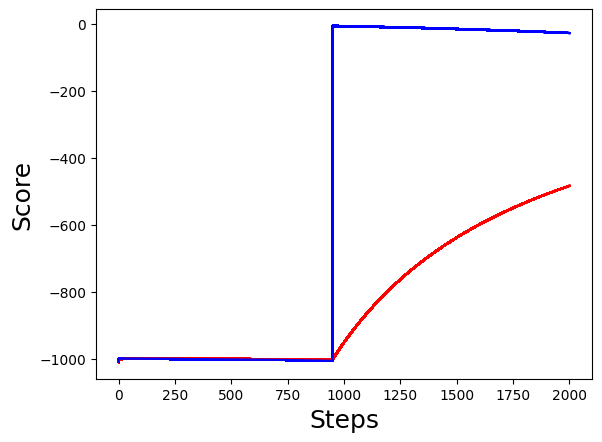

In [3]:
agent.train(n_threads=6)